# 0. Generating the datasets



In [27]:
%rm -rf /content/Diffusion/neuralop
%rm -rf /content/Diffusion/neuralop.egg-info


In [3]:
%pip -q uninstall -y neuralop neuraloperator || true
%pip -q install "git+https://github.com/neuraloperator/neuraloperator.git"

import neuralop, pkgutil, os, inspect

print("neuralop.__file__ =", neuralop.__file__)
print("neuralop.__path__ =", list(neuralop.__path__))

# list top-level subpackages under neuralop
tops = sorted([m.name for m in pkgutil.iter_modules(neuralop.__path__)])
print("top-level under neuralop:", tops)

# ensure the nested package exists
import neuralop.data
print("neuralop.data.__path__ =", list(neuralop.data.__path__))

subs = sorted([m.name for m in pkgutil.iter_modules(neuralop.data.__path__)])
print("subpackages under neuralop.data:", subs)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
neuralop.__file__ = /usr/local/lib/python3.12/dist-packages/neuralop/__init__.py
neuralop.__path__ = ['/usr/local/lib/python3.12/dist-packages/neuralop']
top-level under neuralop: ['data', 'layers', 'losses', 'models', 'mpu', 'tests', 'training', 'utils']
neuralop.data.__path__ = ['/usr/local/lib/python3.12/dist-packages/neuralop/data']
subpackages under neuralop.data: ['datasets', 'transforms']


In [5]:
from pathlib import Path
from neuralop.data.datasets.darcy import DarcyDataset

root = Path("./data/neuralop_darcy").resolve()
ds = DarcyDataset(
    root_dir=root,
    n_train=100,
    n_tests=[24, 32],
    batch_size=8,
    test_batch_sizes=[8,8],
    train_resolution=32,
    test_resolutions=[32, 16],
    download=True,
)

print("root:", root)
print("files:", sorted([p.name for p in root.iterdir()]))
print("exists darcy_test_32:", (root/"darcy_test_32.pt").exists())
print("exists darcy_train_32:", (root/"darcy_train_32.pt").exists())

Loading test db for resolution 32 with 24 samples 
Loading test db for resolution 16 with 32 samples 
root: /content/Diffusion/data/neuralop_darcy
files: ['._darcy_test_16.pt', '._darcy_train_16.pt', 'darcy_16.tgz', 'darcy_32.tgz', 'darcy_test_16.pt', 'darcy_test_32.pt', 'darcy_train_16.pt', 'darcy_train_32.pt']
exists darcy_test_32: True
exists darcy_train_32: True


In [36]:
%ls


: 

In [54]:
%ls data/neuralop_darcy

darcy_32.tgz  darcy_test_32.pt  darcy_train_32.pt


# 1. Setup

Use GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the Git repo. 

In [1]:
!rm -rf /content/Diffusion
%cd /content




/content


In [2]:
!git clone -b fix/dataloader-phys --single-branch https://github.com/Riccardo582/Diffusion.git
%cd Diffusion/


Cloning into 'Diffusion'...
remote: Enumerating objects: 465, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 465 (delta 44), reused 163 (delta 24), pack-reused 280 (from 1)
Receiving objects: 100% (465/465), 6.34 MiB | 19.14 MiB/s, done.
Resolving deltas: 100% (207/207), done.
/content/Diffusion


# Sample from Pre-trained DiT Models (For reference)

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [ ]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

*Verify number of GPU available*

In [44]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())


CUDA available: True
GPU count: 1


**Run the model**

In [6]:
!torchrun --nnodes=1 --nproc_per_node=1 train.py \
  --model DiT-S/2 \
  --data-path /content/Diffusion/data/neuralop_darcy/darcy_train_32.pt \
  --ckpt-every 400 \
  --image-size 32 \
  --cx 1 \
  --cy 1 \
  --epochs 30 \
  --global-batch-size 16 \
  --num-workers 1 \
  --pos-mode grid_sincos 


Starting rank=0, seed=0, world_size=1.
[2026-02-24 14:01:11] Experiment directory created at results/000-DiT-S-2
model_mean_type = ModelMeanType.EPSILON
model_var_type = ModelVarType.FIXED_LARGE
loss_type = LossType.MSE
[2026-02-24 14:01:12] DiT Parameters: 32,466,820
[2026-02-24 14:01:12] Dataset contains 5,000 PDE samples (/content/Diffusion/data/neuralop_darcy/darcy_train_32.pt)
[2026-02-24 14:01:12] Training for 30 epochs...
[2026-02-24 14:01:12] Beginning epoch 0...
x_cond shape: torch.Size([16, 1, 32, 32])
y shape: torch.Size([16, 1, 32, 32])
model type: <class 'torch.nn.parallel.distributed.DistributedDataParallel'>
inner type: <class 'models.DiT'>
inner forward: <bound method DiT.forward of DiT(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(2, 384, kernel_size=(2, 2), stride=(2, 2))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=384, bias=True)
      (1): SiLU()
      (2): Linear(in_features=3

*Plot error curve*

checkpoints  log.txt
Parsed 93 points from results/000-DiT-S-2/log.txt


/usr/local/lib/python3.12/dist-packages/matplotlib/_fontconfig_pattern.py:85: PyparsingDeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/usr/local/lib/python3.12/dist-packages/matplotlib/_fontconfig_pattern.py:89: PyparsingDeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  parser.resetCache()
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2010: PyparsingDeprecationWarning: 'oneOf' deprecated - use 'one_of'
  p.space          = oneOf(self._space_widths)("space")
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:2020: PyparsingDeprecationWarning: 'leaveWhitespace' deprecated - use 'leave_whitespace'
  )("sym").leaveWhitespace()
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:1984: PyparsingDeprecationWarning: 'setName' deprecated - use 'set_name'
  val.setName(key)
/usr/local/lib/python3.12/dist-packages/matplotlib/_mathtext.py:1987: PyparsingDeprecationWarning: 'setParseA

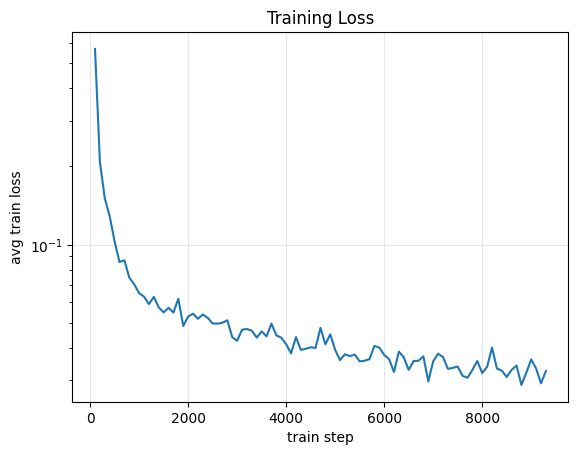

In [7]:

import re
import matplotlib.pyplot as plt

!ls results/000-DiT-S-2

LOG = "results/000-DiT-S-2/log.txt"  

steps, loss = [], []
pat = re.compile(r"\(step=(\d+)\)\s+Train Loss:\s+([0-9.]+)")

with open(LOG, "r") as f:
    for line in f:
        m = pat.search(line)
        if m:
            steps.append(int(m.group(1)))
            loss.append(float(m.group(2)))

print(f"Parsed {len(loss)} points from {LOG}")
if len(loss) == 0:
    raise SystemExit("No loss lines found. Check LOG path or log format")

plt.figure()
plt.semilogy(steps, loss)
plt.xlabel("train step")
plt.ylabel("avg train loss")
plt.title("Training Loss")
plt.grid(alpha=0.3)
plt.show()



Sample from the trained model


In [1]:
!torchrun --nproc_per_node=1 sample_ddp.py \
  --model DiT-S/2 \
  --dataset-pt data/datasets/data/darcy_test_32.pt \
  --ckpt results/000-DiT-S-2/checkpoints/0009200.pt \
  --H 32 --W 32 --cx 1 --cy 1 \
  --per-proc-batch-size 16 \
  --num-fid-samples 256 \
  --pos-mode grid_sincos \
  --sample-dir samples_pde \
  --num-sampling-steps 300 

: 

In [8]:
%ls results/000-DiT-S-2/checkpoints/

0000400.pt  0002000.pt  0003600.pt  0005200.pt  0006800.pt  0008400.pt
0000800.pt  0002400.pt  0004000.pt  0005600.pt  0007200.pt  0008800.pt
0001200.pt  0002800.pt  0004400.pt  0006000.pt  0007600.pt  0009200.pt
0001600.pt  0003200.pt  0004800.pt  0006400.pt  0008000.pt


In [10]:
import numpy as np

path = "samples_pde/samples_rank0000.npz"
d = np.load(path)

# list keys
print("keys:", d.files)

# shapes and data types
for k in d.files:
    v = d[k]
    print(f"{k:10s}  shape={v.shape}  dtype={v.dtype}")

for k in ("H","W","cx","cy","seed","model","ckpt"):
    if k in d.files:
        v = d[k]
        try:
            print(k, v.item())
        except Exception:
            print(k, v)



keys: ['x_cond', 'y_true', 'y_sample', 'H', 'W', 'cx', 'cy', 'model', 'ckpt', 'seed']
x_cond      shape=(256, 1, 32, 32)  dtype=float32
y_true      shape=(256, 1, 32, 32)  dtype=float32
y_sample    shape=(256, 1, 32, 32)  dtype=float32
H           shape=()  dtype=int64
W           shape=()  dtype=int64
cx          shape=()  dtype=int64
cy          shape=()  dtype=int64
model       shape=()  dtype=<U7
ckpt        shape=()  dtype=<U42
seed        shape=()  dtype=int64
H 32
W 32
cx 1
cy 1
seed 0
model DiT-S/2
ckpt results/000-DiT-S-2/checkpoints/0009200.pt


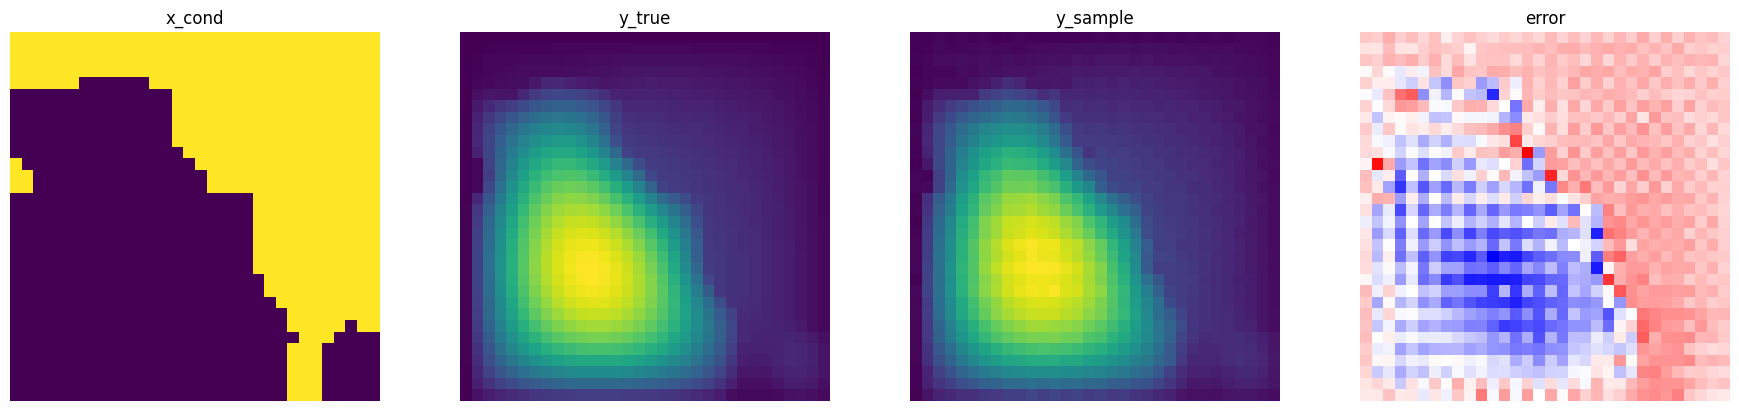

In [11]:

d = np.load(path)
x = d["x_cond"]      # (N,Cx,H,W)
yt = d.get("y_true") # (N,Cy,H,W) or missing
ys = d["y_sample"]   # (N,Cy,H,W)

i = 0
cx = 0
cy = 0

fig, ax = plt.subplots(1, 4 if yt is not None else 2, figsize=(18,4), constrained_layout=True)

ax[0].imshow(x[i, cx]); ax[0].set_title("x_cond"); ax[0].axis("off")
if yt is not None:
    ax[1].imshow(yt[i, cy]); ax[1].set_title("y_true"); ax[1].axis("off")
    ax[2].imshow(ys[i, cy]); ax[2].set_title("y_sample"); ax[2].axis("off")
    ax[3].imshow(ys[i, cy] - yt[i, cy], cmap="bwr"); ax[3].set_title("error"); ax[3].axis("off")
else:
    ax[1].imshow(ys[i, cy]); ax[1].set_title("y_sample"); ax[1].axis("off")

plt.show()


In [12]:
import numpy as np

yt = d["y_true"]
ys = d["y_sample"]
mse = ((ys - yt)**2).mean()
rel = np.sqrt(((ys-yt)**2).mean()) / (np.sqrt((yt**2).mean()) + 1e-12)
print("MSE:", mse, "relative RMSE:", rel)
print("y_true mean/std:", yt.mean(), yt.std())
print("y_samp mean/std:", ys.mean(), ys.std())
print("error mean/std:", (ys-yt).mean(), (ys-yt).std())
print("error min/max:", (ys-yt).min(), (ys-yt).max())


MSE: 0.005679371 relative RMSE: 0.14298882
y_true mean/std: 0.40072787 0.3423361
y_samp mean/std: 0.39521384 0.34411767
error mean/std: -0.0055139977 0.07515961
error min/max: -29.783731 15.18292
